In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy import integrate

# Problem 1

Consider the SIR model, consider modelling of synthetic data, and then make parameter estimation for β and γ.

- Get either an analytical solver, or a numerical solver, which outputs S(t), I(t), R(t).


0.75


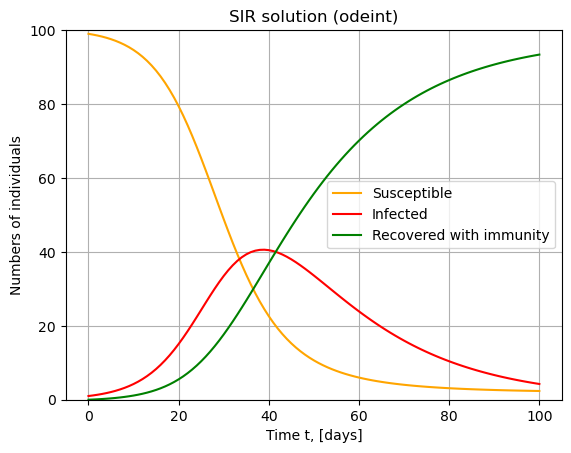

In [23]:
# Adapded from https://scientific-python.readthedocs.io/en/latest/notebooks_rst/3_Ordinary_Differential_Equations/02_Examples/Epidemic_model_SIR.html

N = 100.
I0, R0 = 1.,0
S0 = N - I0 - R0

beta, gamma = .2, .05

tmax = 100
Nt = tmax

t = np.linspace(0, tmax, Nt + 1)

def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * I * S / N
    dIdt = beta * I * S / N - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

res = integrate.odeint(sir_model, (S0, I0, R0), t, args=(beta, gamma))
S,I,R = res.T
Seuil = 1 - 1/(beta/gamma)
print(Seuil)
plt.figure()
plt.grid()
plt.title("SIR solution (odeint)")
plt.plot(t, S, 'orange', label='Susceptible')
plt.plot(t, I, 'r', label='Infected')
plt.plot(t, R, 'g', label='Recovered with immunity')
plt.xlabel('Time t, [days]')
plt.ylabel('Numbers of individuals')
plt.ylim([0,N])
plt.legend()

plt.show();

- Make synthetic test case with noise-perturbed observations, e.g.
Sobserved(t) = Struth(t) + e (1)
where e ∼ N (0, σ2I)

Text(0.5, 0, 'Time t [days]')

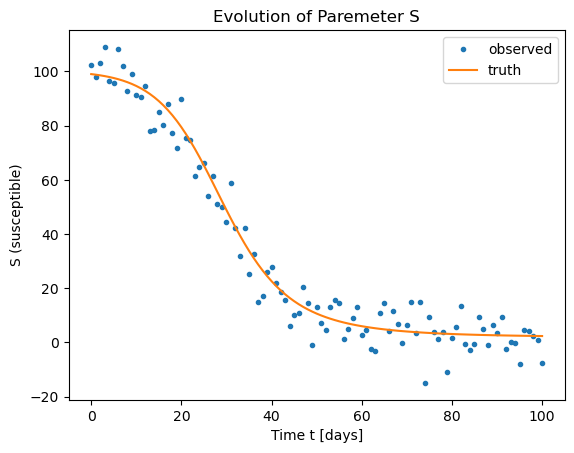

In [24]:
import pandas as pd
from scipy import stats

np.random.seed(42)

err_sigma = (N * .5) ** .5
error_fn = stats.norm(0, err_sigma)
noise = pd.Series(error_fn.rvs(size=S.shape))
Sobs = pd.Series(S + noise)

plt.figure()
Sobs.plot(style='.',label='observed')
pd.Series(S).plot(label='truth')
plt.legend()
plt.title("Evolution of Paremeter S")
plt.ylabel('S (susceptible)')
plt.xlabel("Time t [days]")

- Write posterior distribution for (β, γ)⊺.

Define SIR model:

$$
\dot S = -\beta/N I(t) S(t) \\
\dot I = \beta/N I(t) S(t) - \gamma I(t) \\
\dot R = \gamma I(t)
$$

Annotate $$\theta = [\beta, \gamma]^T$$


Start from bayes theorem:

$$ 
P(\theta | S(t) ) \propto P(S(t) | \theta) P(\theta)
$$

Which expands to 
$$
= P(\theta) \frac{ 1 } {\sqrt{((2\pi)^{n} |\Sigma|)}} \exp(-1/2 S(t)^T \Sigma^{-1} S(t) )
$$




- Use MCMC to get posterior estimates and uncertainty quantification,
and evaluate MCMC chains.


/tmp/ipykernel_8600/2182796702.py:56: RuntimeWarning: overflow encountered in exp
  acceptance_ratio = np.exp(log_posterior_proposed - log_posterior_current)


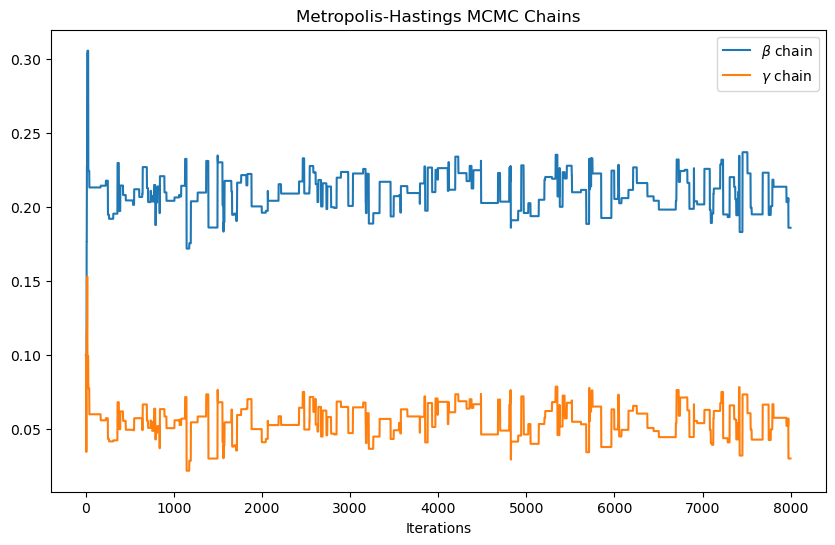

In [41]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt


# Metropolis-Hastings MCMC algorithm
def metropolis_hastings_mcmc(Sobs, iterations, proposal_std):
    # Initial parameter values
    beta_current, gamma_current = 0.1, 0.1

    # Number of data points
    N = len(Sobs)

    # Proposal function (normal distribution)
    def propose_parameters(beta, gamma):
        beta_proposed = stats.norm(beta, proposal_std).rvs()
        gamma_proposed = stats.norm(gamma, proposal_std).rvs()
        return beta_proposed, gamma_proposed

    # Prior function (assuming flat priors)
    def prior(beta, gamma):
        return 1.0

    # Log likelihood function
    def log_likelihood(Y, X, sigma):
        return -0.5 / sigma**2 * np.linalg.norm(Y - X)**2

    # Run MCMC
    beta_chain, gamma_chain = [], []
    t = np.linspace(0, tmax, Nt + 1)
    sigma = err_sigma
    
    for _ in range(iterations):
        # Simulate SIR model for current parameters
        sir_solution_current = odeint(sir_model, [S0, I0, R0], t, args=(beta_current, gamma_current))
        S_current = sir_solution_current[:, 0]

        # Propose new parameters
        beta_proposed, gamma_proposed = propose_parameters(beta_current, gamma_current)

        # Simulate SIR model for proposed parameters
        sir_solution_proposed = odeint(sir_model, [S0, I0, R0], t, args=(beta_proposed, gamma_proposed))
        S_proposed = sir_solution_proposed[:, 0]

        # Compute prior, log likelihood, and posterior
        prior_current = prior(beta_current, gamma_current)
        prior_proposed = prior(beta_proposed, gamma_proposed)
        log_likelihood_current = log_likelihood(Sobs, S_current, sigma)
        log_likelihood_proposed = log_likelihood(Sobs, S_proposed, sigma)

        log_posterior_current = np.log(prior_current) + log_likelihood_current
        log_posterior_proposed = np.log(prior_proposed) + log_likelihood_proposed

        # Accept or reject the proposal
        acceptance_ratio = np.exp(log_posterior_proposed - log_posterior_current)
        if np.random.uniform(0, .3) < acceptance_ratio:
            beta_current, gamma_current = beta_proposed, gamma_proposed

        # Save current parameters to chains
        beta_chain.append(beta_current)
        gamma_chain.append(gamma_current)

    return np.array(beta_chain), np.array(gamma_chain)

# Example usage
# Assuming Sobs is the measured data (pandas series)
N = len(Sobs)
S0, I0, R0 = int(Sobs.iloc[0]), 1, 0  # Initial conditions

# Set the standard deviation for the proposal distribution
proposal_std = .05

# Number of MCMC iterations
iterations = 8000

# Run MCMC
beta_chain, gamma_chain = metropolis_hastings_mcmc(Sobs.values, iterations, proposal_std)

# Plot MCMC chains
plt.figure(figsize=(10, 6))
plt.plot(beta_chain, label=r'$\beta$ chain')
plt.plot(gamma_chain, label=r'$\gamma$ chain')
plt.legend()
plt.title('Metropolis-Hastings MCMC Chains')
plt.xlabel('Iterations')
plt.show()

In [42]:
# Discard burn-in period
beta_chain = beta_chain[500:]
gamma_chain = gamma_chain[500:]

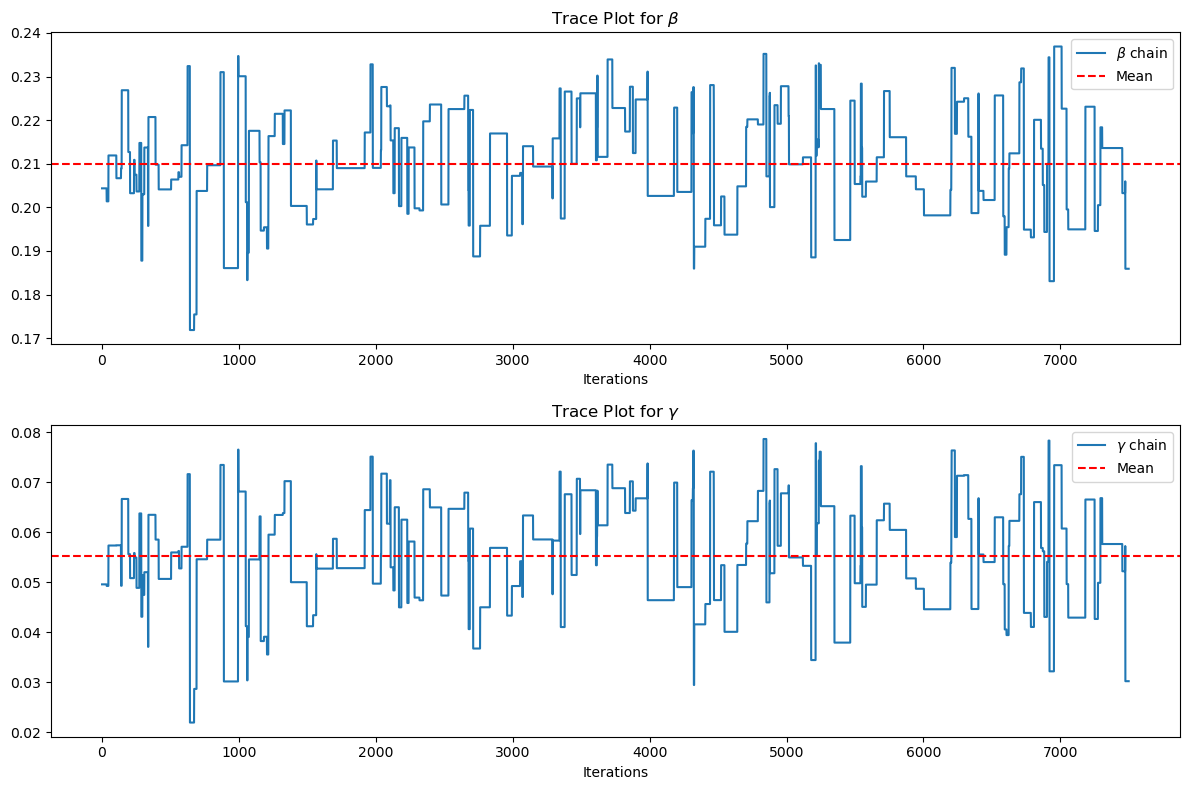

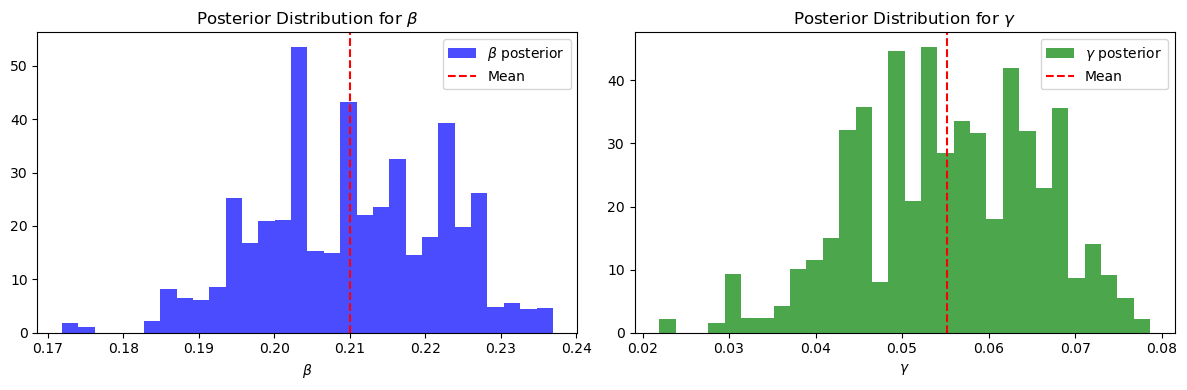

In [43]:
# Plot trace plots
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(beta_chain, label=r'$\beta$ chain')
plt.axhline(np.mean(beta_chain), color='red', linestyle='dashed', label='Mean')
plt.title(r'Trace Plot for $\beta$')
plt.xlabel('Iterations')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(gamma_chain, label=r'$\gamma$ chain')
plt.axhline(np.mean(gamma_chain), color='red', linestyle='dashed', label='Mean')
plt.title(r'Trace Plot for $\gamma$')
plt.xlabel('Iterations')
plt.legend()

plt.tight_layout()
plt.show()

# Plot posterior distributions
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(beta_chain, bins=30, density=True, alpha=0.7, color='blue', label=r'$\beta$ posterior')
plt.axvline(np.mean(beta_chain), color='red', linestyle='dashed', label='Mean')
plt.title(r'Posterior Distribution for $\beta$')
plt.xlabel(r'$\beta$')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(gamma_chain, bins=30, density=True, alpha=0.7, color='green', label=r'$\gamma$ posterior')
plt.axvline(np.mean(gamma_chain), color='red', linestyle='dashed', label='Mean')
plt.title(r'Posterior Distribution for $\gamma$')
plt.xlabel(r'$\gamma$')
plt.legend()

plt.tight_layout()
plt.show()

- Plot predictive intervals.

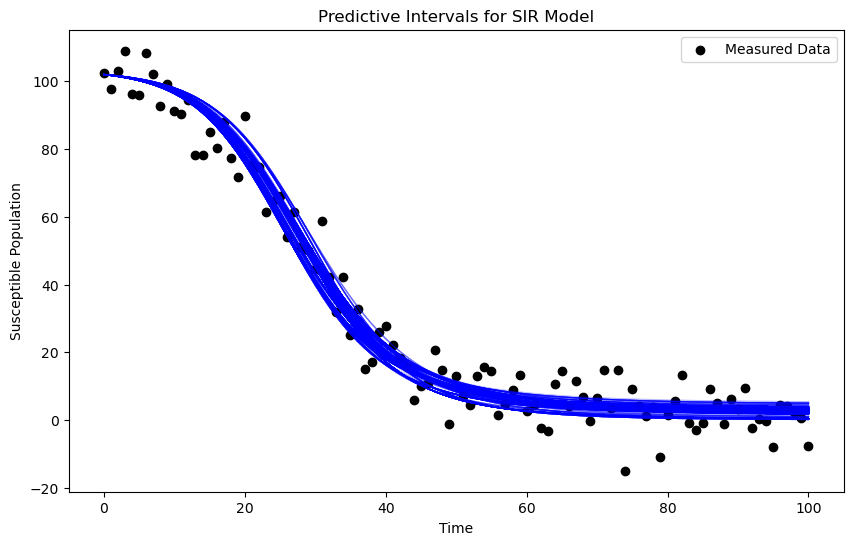

In [45]:
# Function to simulate multiple trajectories
def simulate_trajectories(parameters, num_trajectories, t):
    trajectories = []
    for i in range(num_trajectories):
        beta, gamma = parameters[i]
        sir_solution = odeint(sir_model, [S0, I0, R0], t, args=(beta, gamma))
        S_trajectory = sir_solution[:, 0]
        trajectories.append(S_trajectory)
    return np.array(trajectories)

# Number of trajectories to simulate
num_trajectories = 1000

# Simulate trajectories using MCMC samples
parameters_samples = np.column_stack((beta_chain[100:], gamma_chain[100:]))
trajectories = simulate_trajectories(parameters_samples, num_trajectories, t)

# Plot predictive intervals
plt.figure(figsize=(10, 6))

# Plot measured data
plt.scatter(t, Sobs, color='black', marker='o', label='Measured Data')

# Plot simulated trajectories
for i in range(num_trajectories):
    plt.plot(t, trajectories[i], color='blue', alpha=0.1, linewidth=1)

plt.title('Predictive Intervals for SIR Model')
plt.xlabel('Time')
plt.ylabel('Susceptible Population')
plt.legend()
plt.show()

## Problem 2
Take one realisation of white noise, form posterior distribution, and obtain variance estimate with MCMC. Make the standard plots.

Generate white noise.

In [46]:
import numpy as np

np.random.seed(42)  # Set seed for reproducibility
white_noise = np.random.normal(0, 1, size=100)  # Adjust size as needed

In [47]:
import pymc as pm

with pm.Model() as model:
    sigma = pm.HalfNormal('sigma', sigma=1)  # Prior for the standard deviation (positive values only)
    obs = pm.Normal('obs', mu=0, sigma=sigma, observed=white_noise)

In [48]:
with model:
    trace = pm.sample(1000, tune=1000, cores=4)  # Adjust the number of samples and tuning steps

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

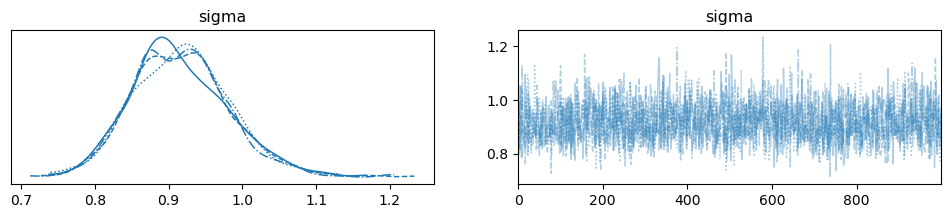

In [49]:
pm.plot_trace(trace)

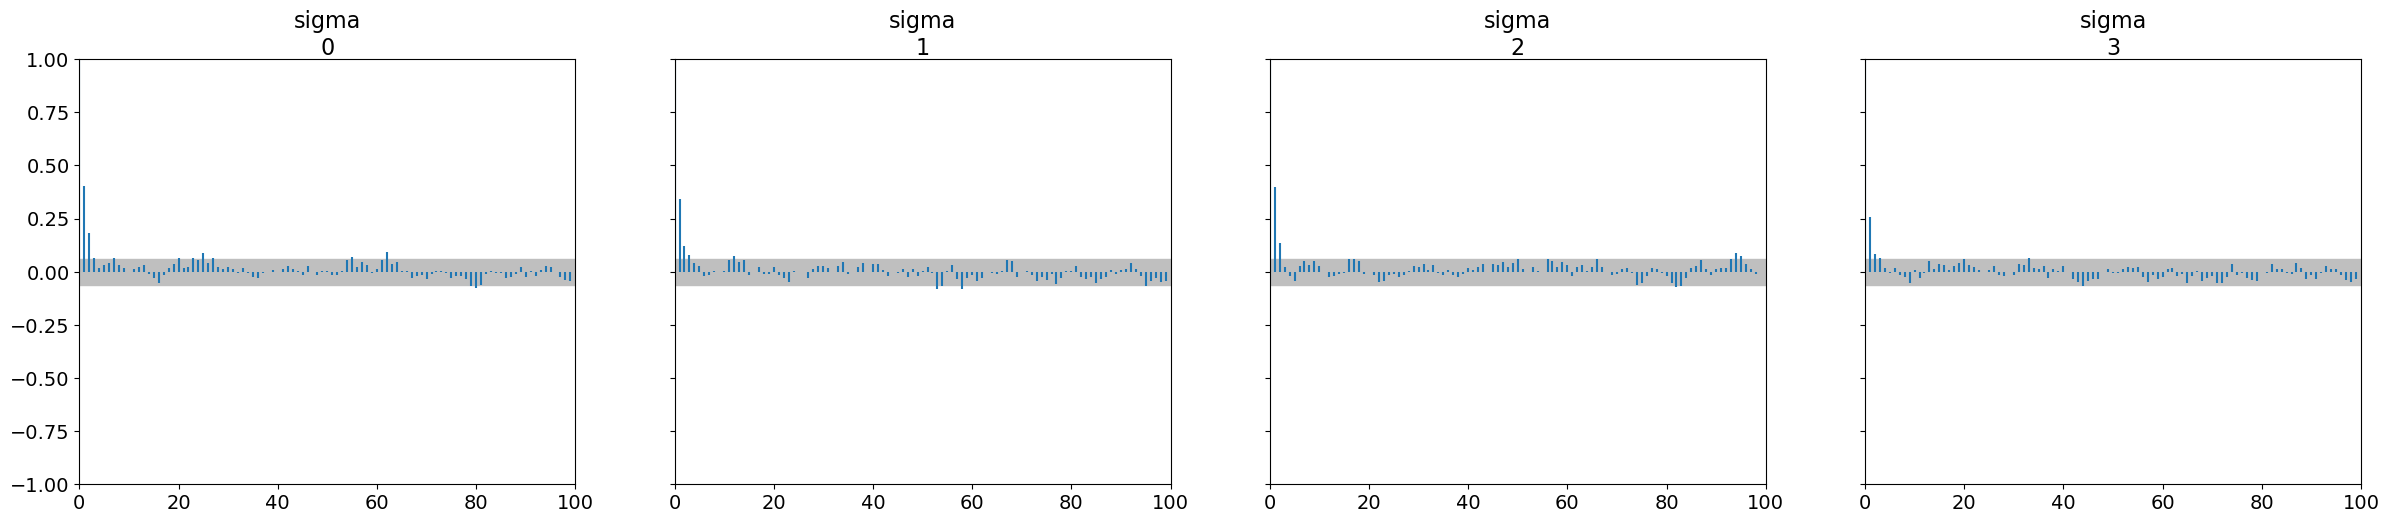

In [50]:
pm.plot_autocorr(trace);

Posterior analysis:

In [51]:
posterior_samples = trace['posterior']['sigma']
estimated_variance = np.mean(posterior_samples)
print("Estimated Variance:", estimated_variance)

Estimated Variance: <xarray.DataArray 'sigma' ()>
array(0.9168637)


<Axes: title={'center': 'sigma'}>

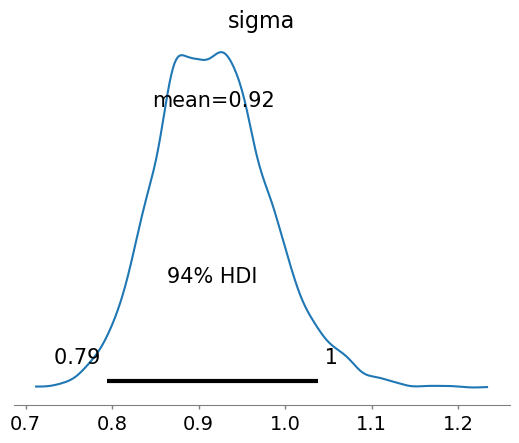

In [52]:
pm.plot_posterior(trace)

## Problem 3

Given one realisation of the Ornstein-Uhlenbeck process with fixed σ,
use MCMC to obtain CM-estimate of λ. That is,

- Draw one realisation of the OU process.
- Formulate the posterior of λ.
- Use MCMC to estimate λ.
- Plot chains, ACFs, densities and compute ESS and OES.
- Visualise posterior parameter estimates and Monte Carlo errors

In [53]:
import numpy as np

np.random.seed(42)

def ornstein_uhlenbeck(delta, theta, sigma, x0, n, dt=0.1):
    ou_process = np.zeros(n)
    ou_process[0] = x0
    for t in range(1, n):
        drift = theta * (delta - ou_process[t - 1]) * dt
        diffusion = sigma * np.sqrt(dt) * np.random.normal(0, 1)
        ou_process[t] = ou_process[t - 1] + drift + diffusion
    return ou_process

# Set parameters
delta = 0.0  # Mean-reverting level
theta_true = 1.0  # Mean-reversion parameter (to be estimated)
sigma_true = 0.2  # Volatility parameter
x0 = 0.0  # Initial value
n = 100  # Number of time steps

# Generate OU process realization
ou_data = ornstein_uhlenbeck(delta, theta_true, sigma_true, x0, n)


Define model with OU process data.

In [57]:
import pymc as pm

with pm.Model() as model_ou:
    lambda_ = pm.Exponential('lambda_', lam=1)  # Prior for the mean-reversion parameter
    obs = pm.Normal('obs', mu=delta + lambda_ * (ou_data[:-1] - delta), 
                    sigma=sigma_true, observed=ou_data[1:])

In [58]:
# Sample
with model_ou:
    trace_ou = pm.sample(1000, tune=1000, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [lambda_]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
lambda_,0.88,0.14,0.61,1.16,0.0,0.0,1309.0,1650.0,1.0


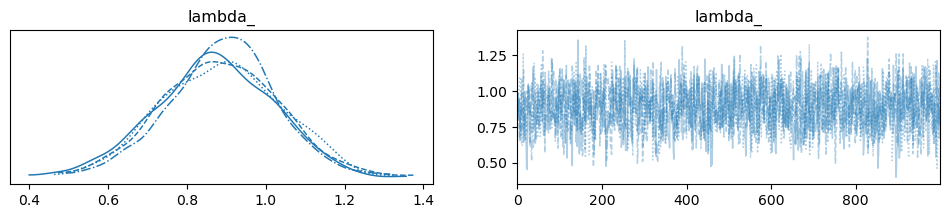

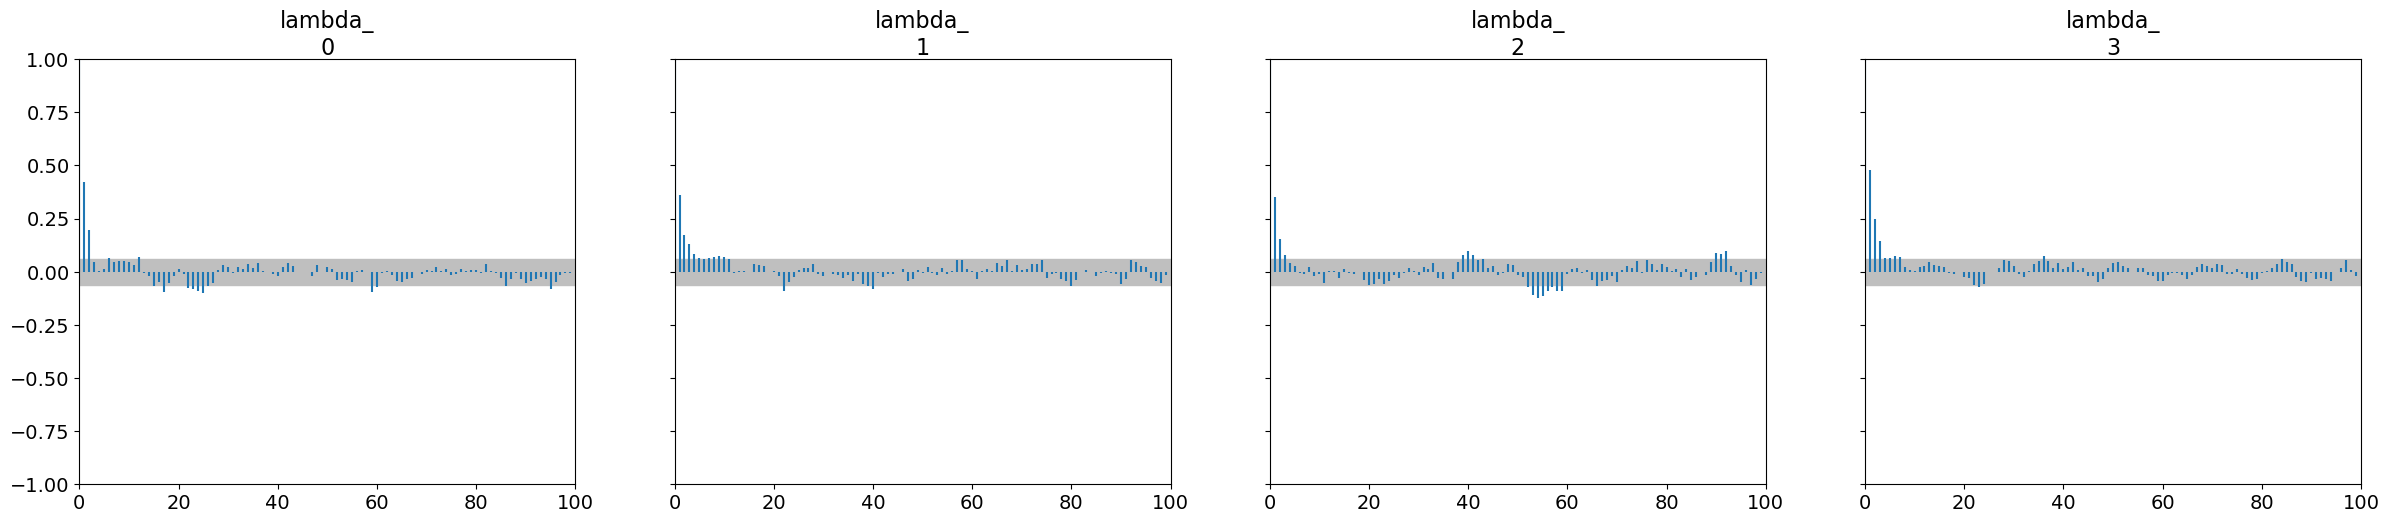

In [59]:
pm.plot_trace(trace_ou)
pm.plot_autocorr(trace_ou)
pm.summary(trace_ou).round(2)

In [60]:
posterior_samples_ou = trace_ou['posterior']['lambda_']
estimated_lambda = np.mean(posterior_samples_ou)
print("Estimated Lambda:", estimated_lambda)

Estimated Lambda: <xarray.DataArray 'lambda_' ()>
array(0.88323188)


<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    lambda_  (chain, draw) float64 0.8209 0.8209 0.8704 ... 0.671 0.8465 0.8558
Attributes:
    created_at:                 2024-01-31T18:35:13.088214
    arviz_version:              0.17.0
    inference_library:          pymc
    inference_library_version:  5.10.0
    sampling_time:              1.3804991245269775
    tuning_steps:               1000

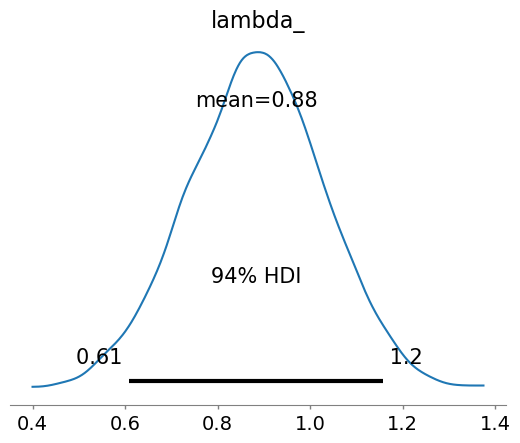

In [66]:
pm.plot_posterior(trace_ou);

# Compute ESS and OES
# ess = pm.ess(trace_ou)
# oes = pm.oes(trace_ou)

trace_ou.posterior
# print("Effective Sample Size:", ess)
# print("OES (Overlapping Estimate of Effective Sample Size):", oes)

2. In order to see different behaviour of priors, do the same as above, but
with different priors. Use a Gaussian prior.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda_]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Summary Statistics for Exponential Prior:
         mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
lambda_  0.84  0.1    0.66      1.0        0.0      0.0     622.0     611.0   

         r_hat  
lambda_    1.0  


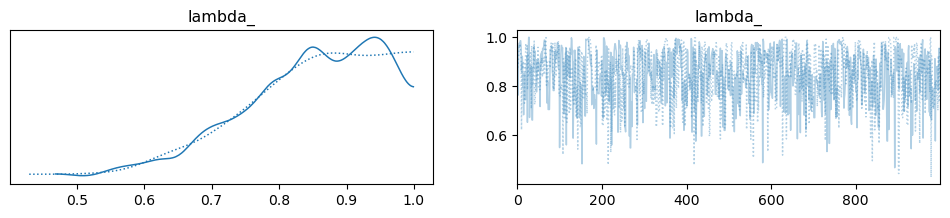

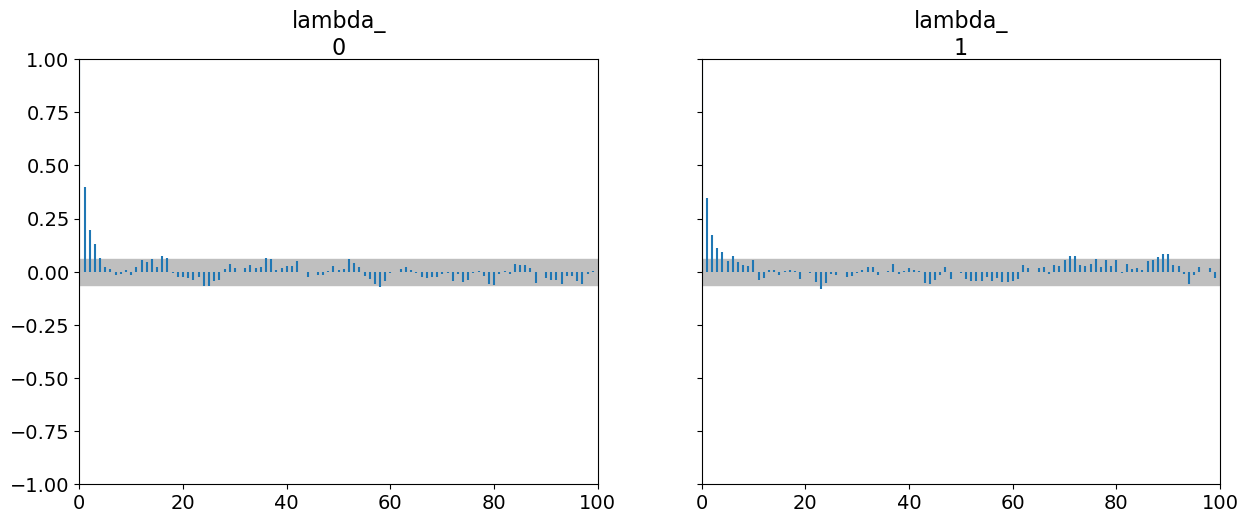

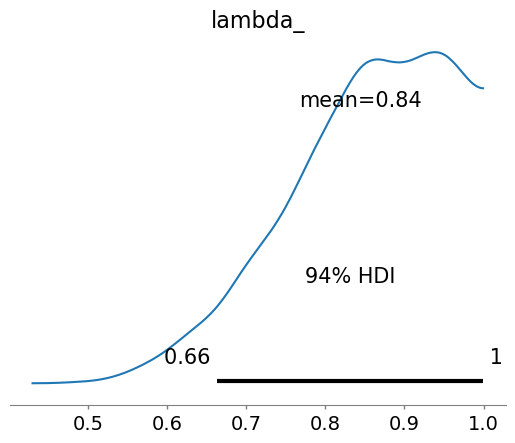

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda_]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Summary Statistics for Gaussian Prior:
         mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
lambda_  0.84  0.1    0.66      1.0        0.0      0.0     696.0     549.0   

         r_hat  
lambda_   1.01  


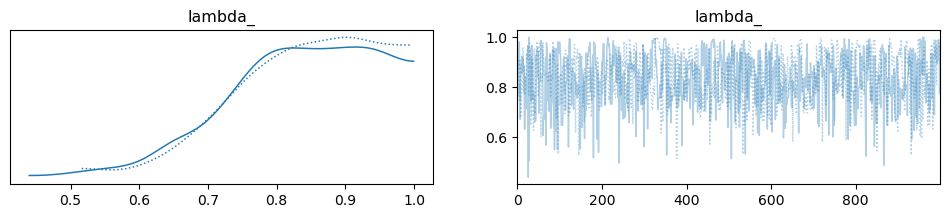

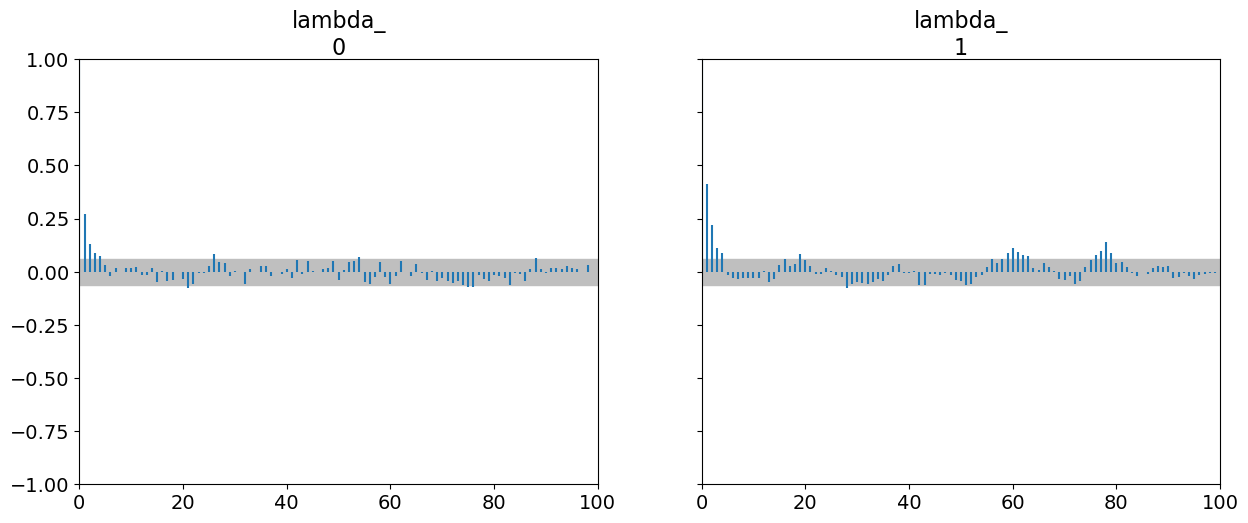

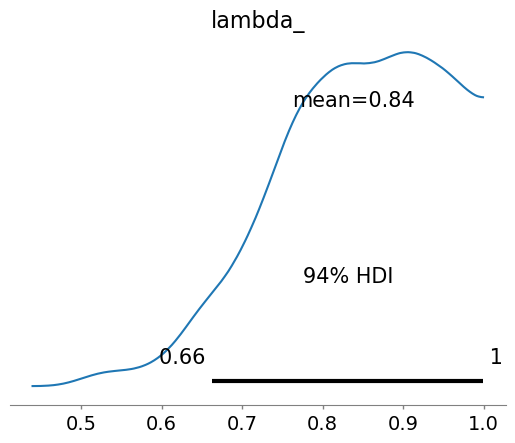

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lambda_]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Summary Statistics for Flat Prior:
         mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
lambda_  0.85  0.1    0.67      1.0        0.0      0.0     447.0     535.0   

         r_hat  
lambda_    1.0  


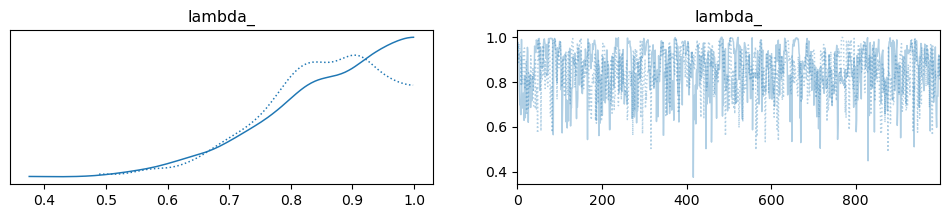

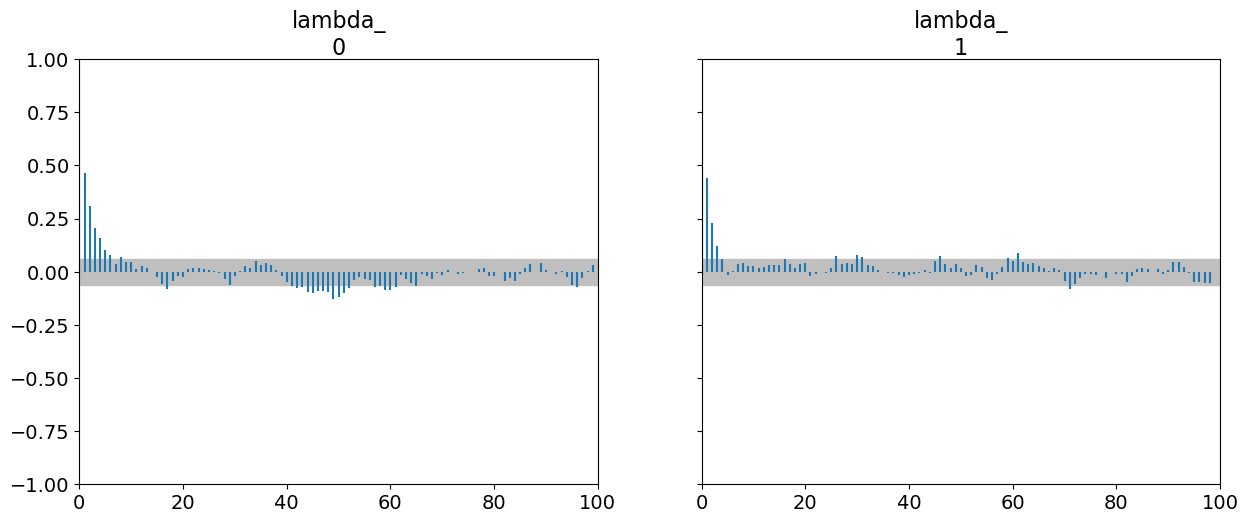

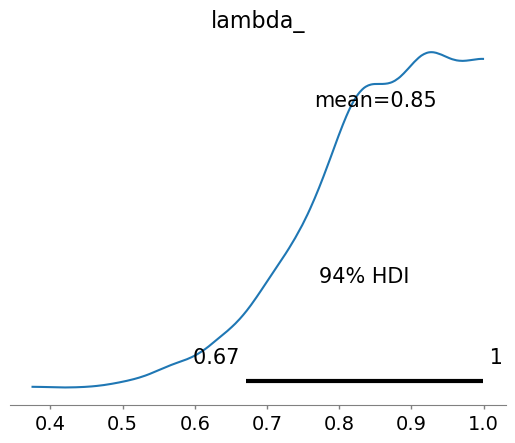

In [72]:
import numpy as np
import pymc as pm
import arviz as az

np.random.seed(42)

def ornstein_uhlenbeck(delta, theta, sigma, x0, n, dt=0.1):
    ou_process = np.zeros(n)
    ou_process[0] = x0
    for t in range(1, n):
        drift = theta * (delta - ou_process[t - 1]) * dt
        diffusion = sigma * np.sqrt(dt) * np.random.normal(0, 1)
        ou_process[t] = ou_process[t - 1] + drift + diffusion
    return ou_process

def create_ou_model(prior_lambda):
    with pm.Model() as model_ou:
        lambda_ = pm.Exponential('lambda_', lam=1) if prior_lambda == 'exponential' else \
                   pm.Normal('lambda_', mu=0, sigma=err_sigma) if prior_lambda == 'gaussian' else \
                   pm.Uniform('lambda_')  # Flat prior
                   
        obs = pm.Normal('obs', mu=delta + lambda_ * (ou_data[:-1] - delta), sigma=sigma_true, observed=ou_data[1:])
    
    return model_ou

def report_and_plot(trace, prior_name):
    # Plot chains, ACFs, and densities
    pm.plot_trace(trace)
    pm.plot_autocorr(trace)
    pm.plot_posterior(trace)
    
    # Compute and print summary statistics
    summary = pm.summary(trace).round(2)
    print("Summary Statistics for", prior_name, "Prior:")
    print(summary)
    
    # Display the plots
    plt.show()

# Set parameters
delta = 0.0
theta_true = 1.0
sigma_true = 0.2
x0 = 0.0
n = 100

# Generate OU process realization
ou_data = ornstein_uhlenbeck(delta, theta_true, sigma_true, x0, n)

# Priors to compare
prior_names = ['Exponential', 'Gaussian', 'Flat']

for prior_name in prior_names:
    # Create the OU model with the specified prior
    model_ou = create_ou_model(prior_name)

    # MCMC sampling
    with model_ou:
        trace_ou = pm.sample(1000, tune=1000, cores=2)

    # Plotting and reporting
    report_and_plot(trace_ou, prior_name)


... and that's it, folks. That's as much as I can do given this timeframe. Till next time.